In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
from google.colab.patches import cv2_imshow
import os

In [ ]:
path = '/content/drive/MyDrive/Thesis/Media Data Filtering/Dataset/mp4_files'
lst = []

for subdir, dirs, files in os.walk(path):
  files.sort()
  i = 0
  for file in files:
    i += 1
    if file[4:5] == '6':
      print(file)
  print(i)

## Define hyperparameters


In [13]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 8

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

## Data preparation

In [14]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x - min_dim)//2
    start_y = (y - min_dim)//2
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()
    return np.array(frames)


In [15]:

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
import time

path = '/content/drive/MyDrive/Thesis/Media Data Filtering/Dataset/mp4_files'
labels = []
lst = []

start_time = time.time()
# `frame_masks` and `frame_features` are what we will feed to our sequence model.
# `frame_masks` will contain a bunch of booleans denoting if a timestep is
# masked with padding or not.

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        # Gather all its frames and add a batch dimension.
        print(file)
        frames = load_video(os.path.join(subdir,file))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        lst.append(temp_frame_features.squeeze())
        class_id = int(file[4:5]) - 1 
        labels.append(class_id)
      except ValueError:
        continue
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

In [ ]:
X = np.array(lst)
y = np.array(labels)

In [ ]:
X.shape

(9490, 20, 2048)

In [18]:
# Saving joblib files to not load them again with the loop above

import joblib

In [ ]:
X_name = 'X_video1.joblib'
y_name = 'y_video1.joblib'
save_dir = '/content/drive/MyDrive/Thesis/Media Data Filtering/Preprocessed_data'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [19]:
# Loading saved preprocessed data

X = joblib.load('/content/drive/MyDrive/Thesis/Media Data Filtering/Preprocessed_data/X_video1.joblib')
y = joblib.load('/content/drive/MyDrive/Thesis/Media Data Filtering/Preprocessed_data/y_video1.joblib')

In [20]:
X.shape

(9490, 20, 2048)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
len(np.unique(y_train))

6

## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`.

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(np.unique(y_train)), activation="softmax")(x)

    rnn_model = keras.Model(frame_features_input, output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    seq_model = get_sequence_model()
    history = seq_model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
    )

    _, accuracy = seq_model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

## Inference

In [ ]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])

    return frame_features, frame_mask


def sequence_prediction(path):
    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {i+1}: {probabilities[i] * 100:5.2f}%")
    return frames

test_video = '/content/drive/MyDrive/Thesis/Media Data Filtering/Dataset/mp4_files/01_02_10_11'
test_frames = sequence_prediction(test_video)

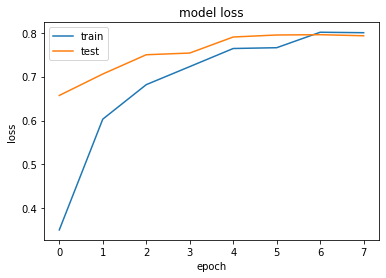

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

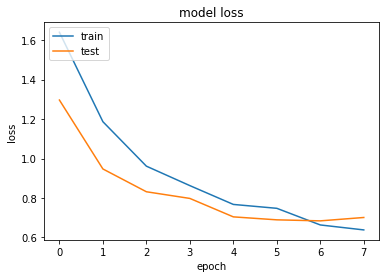

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
predict_x=sequence_model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [37]:
from sklearn.metrics import classification_report
report = classification_report(y_test, classes_x)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       460
           1       0.90      0.78      0.84       483
           2       0.68      0.67      0.68       476
           3       0.84      0.79      0.82       476
           4       0.72      0.86      0.78       473
           5       0.80      0.90      0.85       479

    accuracy                           0.79      2847
   macro avg       0.80      0.79      0.79      2847
weighted avg       0.80      0.79      0.79      2847



In [38]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, classes_x)
print (matrix)

[[346   7  32  18  43  14]
 [  8 378  33  18  15  31]
 [ 23  20 321  22  48  42]
 [ 13   4  43 375  35   6]
 [  2   4  36   8 406  17]
 [  6   8  10   3  20 432]]


In [40]:
model_name = 'video_classification_with_video_1.h5'
save_dir = '/content/drive/MyDrive/Thesis/Media Data Filtering/Saved_Model'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
sequence_model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Thesis/Media Data Filtering/Saved_Model/video_classification_with_video_1.h5 


In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/Thesis/Media Data Filtering/Saved_Model/video_classification_with_video_1.h5')
loaded_model.summary()

In [42]:
loss, acc = loaded_model.evaluate(X_test, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

89/89 [==============================] - 2s 10ms/step - loss: 0.7010 - accuracy: 0.7931
Restored model, accuracy: 79.31%


In [43]:
predict_x=loaded_model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, classes_x)
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, classes_x)
print (matrix)